## Fascinating information about this historic tragedy

[Crew of the Titanic](https://en.wikipedia.org/wiki/Crew_of_the_Titanic)

[Passengers of the Titanic](https://en.wikipedia.org/wiki/Passengers_of_the_Titanic)

[Ship Dimensions and layout](https://en.wikipedia.org/wiki/Titanic#Dimensions_and_layout)
 


## Setup the environment

In [43]:
import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as  plt
# static images of your plot embedded in the notebook
%matplotlib inline  


from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



## Loading data

There are 10 input features. Target is 'Survived'.
The training set contains 891 records while the testing set has 418.

In [55]:
X = pd.read_csv("train.csv", index_col=0)
X_test = pd.read_csv("test.csv", index_col=0)

print('Training data shape: ' + str(X.shape))
print('Testing data shape: ' + str(X_test.shape))

Training data shape: (891, 11)
Testing data shape: (418, 10)


In [56]:
X.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<AxesSubplot:xlabel='Ticket', ylabel='count'>

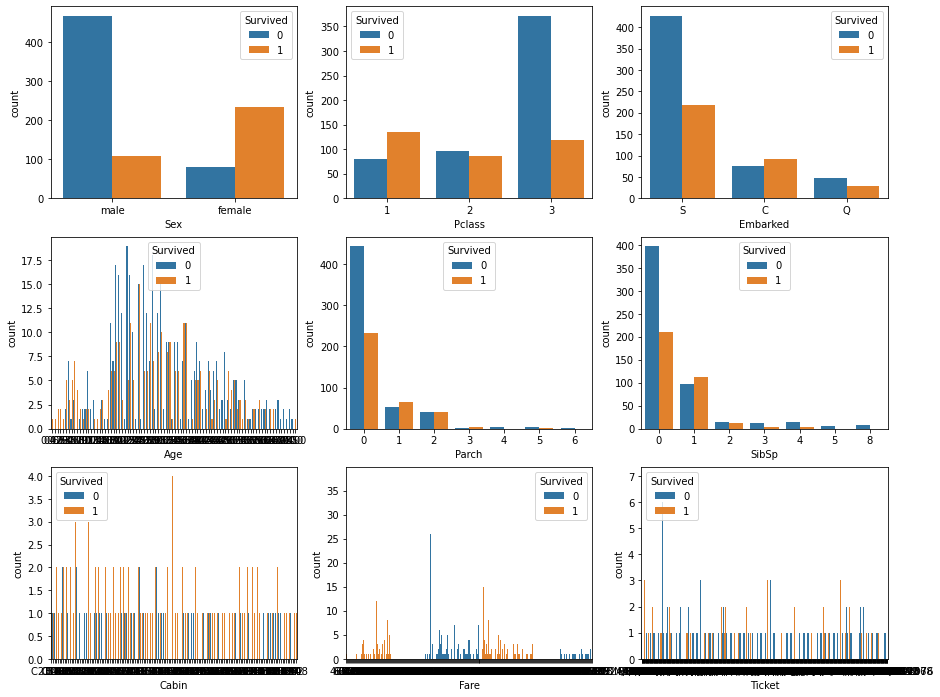

In [36]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(3,3,1)
ax = sns.countplot(x='Sex',hue='Survived',data=X)
fig.add_subplot(3,3,2)
sns.countplot(x='Pclass',hue='Survived', data=X)
fig.add_subplot(3,3,3)
df = X[X.Embarked.notna()]
sns.countplot(x=df.Embarked, hue='Survived', data=df)
fig.add_subplot(3,3,4)
sns.countplot(x='Age', hue='Survived', data=X)
fig.add_subplot(3,3,5)
sns.countplot(x='Parch',hue='Survived', data=X)
fig.add_subplot(3,3,6)
sns.countplot(x='SibSp',hue='Survived', data=X)
fig.add_subplot(3,3,7)
sns.countplot(x='Cabin',hue='Survived', data=X)
fig.add_subplot(3,3,8)
sns.countplot(x='Fare',hue='Survived', data=X)
fig.add_subplot(3,3,9)
sns.countplot(x='Ticket',hue='Survived', data=X)

In [58]:
def rstr(X, pred):
    rows = X.shape[0]
    types = X.dtypes
    counts = X.apply(lambda x: x.count())
    uniques = X.apply(lambda x: x.unique())
    uniques_count = X.apply(lambda x: x.unique().shape[0])
    nulls = X.apply(lambda x: x.isnull().sum())
    missing_rate = (X.isnull().sum()/ rows) * 100
    skewness = X.skew()
    kurtosis = X.kurt() 
    
    if pred is None:
        cols = ['types', 'counts', 'nulls', 'missing rate', 'unique value count', 'unique value', 'skewness', 'kurtosis']
        values = pd.concat([types, counts, nulls, missing_rate, uniques_count, uniques, skewness, kurtosis], axis = 1)
    else:
        cols = ['types', 'counts', 'nulls', 'missing_rate', 'unique value count', 'unique value', 'skewness', 'kurtosis', 'corr '  + pred]
        values = pd.concat([types, counts, nulls, missing_rate, uniques_count, uniques, skewness, kurtosis, X.corr()[pred]], axis = 1, sort=False)
        
    values.columns = cols
    dtypes = values.types.value_counts()
    print('___________________________\nData types:\n',  values.types.value_counts())
    print('___________________________')
    return values

details = rstr(X, 'Survived')
display(details.sort_values(by='corr Survived', ascending=False))

___________________________
Data types:
 object     5
int64      4
float64    2
Name: types, dtype: int64
___________________________


,types,counts,nulls,missing_rate,unique value count,unique value,skewness,kurtosis,corr Survived
Survived,int64,891,0,0.000000,2,"[0, 1]",0.478523,-1.775005,1.000000
Fare,float64,891,0,0.000000,248,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....",4.787317,33.398141,0.257307
Parch,int64,891,0,0.000000,7,"[0, 1, 2, 5, 3, 4, 6]",2.749117,9.778125,0.081629
SibSp,int64,891,0,0.000000,7,"[1, 0, 3, 4, 2, 5, 8]",3.695352,17.880420,-0.035322
Age,float64,714,177,19.865320,89,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...",0.389108,0.178274,-0.077221
Pclass,int64,891,0,0.000000,3,"[3, 1, 2]",-0.630548,-1.280015,-0.338481
Name,object,891,0,0.000000,891,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B...",NaN,NaN,NaN
Sex,object,891,0,0.000000,2,"[male, female]",NaN,NaN,NaN
Ticket,object,891,0,0.000000,681,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803...",NaN,NaN,NaN
Cabin,object,204,687,77.104377,148,"[nan, C85, C123, E46, G6, C103, D56, A6, C23 C...",NaN,NaN,NaN


In [59]:
details = rstr(X_test, None)
display(details)

___________________________
Data types:
 object     5
int64      3
float64    2
Name: types, dtype: int64
___________________________


,types,counts,nulls,missing rate,unique value count,unique value,skewness,kurtosis
Pclass,int64,418,0,0.000000,3,"[3, 2, 1]",-0.534170,-1.382666
Name,object,418,0,0.000000,418,"[Kelly, Mr. James, Wilkes, Mrs. James (Ellen N...",NaN,NaN
Sex,object,418,0,0.000000,2,"[male, female]",NaN,NaN
Age,float64,332,86,20.574163,80,"[34.5, 47.0, 62.0, 27.0, 22.0, 14.0, 30.0, 26....",0.457361,0.083783
SibSp,int64,418,0,0.000000,7,"[0, 1, 2, 3, 4, 5, 8]",4.168337,26.498712
Parch,int64,418,0,0.000000,8,"[0, 1, 3, 2, 4, 6, 5, 9]",4.654462,31.412513
Ticket,object,418,0,0.000000,363,"[330911, 363272, 240276, 315154, 3101298, 7538...",NaN,NaN
Fare,float64,417,1,0.239234,170,"[7.8292, 7.0, 9.6875, 8.6625, 12.2875, 9.225, ...",3.687213,17.921595
Cabin,object,91,327,78.229665,77,"[nan, B45, E31, B57 B59 B63 B66, B36, A21, C78...",NaN,NaN
Embarked,object,418,0,0.000000,3,"[Q, S, C]",NaN,NaN


## Data pre-processing

### Missing values:
* Both training and testing data has big portion of "Cabin" information missing. About 77% for training, 78% for testing. 2/3 of them are passengers in 3rd. class. Cabin location may play a important role in a passenger's survival since it decides the escaping route. While it is difficult to fill in this piece of infromation for each of the passenger, I'll try to introduce a new feature to capture the 'Deck' where the cabins located based on historical data for different class of passengers.  
    
* Close to 20% of Age info is missing from both of the datasets. I'm going to fill them with random numbers between the standard deviation of mean.
    
* Training set missing 2 'Embarked'. The two ladies are both in first class cabin B28 and are the only two on the same tickets with no other relatives. I am using mode() to fillna. 
    
* Testing set has 1 missing 'Fare'. Cross examination didn't find more information. I am using mean ticket price for 3rd class passenger embarked from the same port.

*note: Concate the train and test data together helps revealing some information since people belong to one family or travel together can be examed side by side


In [39]:
# pd.set_option('display.max_rows', None)
# X_test['Survived'] = 3
# pd.concat([X, X_test]).sort_values(by='Fare', ascending=False) 

In [60]:
cabins = X[X['Cabin'].notnull()]['Cabin']
for i in cabins.index:
    X.loc[i,'Deck'] = cabins[i][0]
    
X['Deck'] = X[['Deck','Fare']].sort_values(['Fare'])['Deck'].fillna(method='ffill')
X['Deck'] = X[['Deck','Fare']].sort_values(['Fare'])['Deck'].fillna(method='bfill')


cabins = X_test[X_test['Cabin'].notnull()]['Cabin']
for i in cabins.index:
    X_test.loc[i,'Deck'] = cabins[i][0]
    
X_test['Deck'] = X_test[['Deck','Fare']].sort_values(['Fare'])['Deck'].fillna(method='ffill')
X_test['Deck'] = X_test[['Deck','Fare']].sort_values(['Fare'])['Deck'].fillna(method='bfill')

In [41]:
X["Age"].mean(), X['Age'].std(), X['Age'].isnull().sum()
X_test["Age"].mean(), X_test['Age'].std(), X_test['Age'].isnull().sum()

def Fillna_Age(data):
    mean = data["Age"].mean()
    std = data["Age"].std()
    is_null = data["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    
    # fill NaN values in Age column with random values generated
    age_slice = data["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    data["Age"] = age_slice
    data["Age"] = data["Age"].astype(int)
    
# fill train set missing value for Age
Fillna_Age(X)
print('training data null Age count: ' + str(X.Age.isnull().sum()))
# fill test set missing value for Age
Fillna_Age(X_test)
print('test data null Age count: ' + str(X_test.Age.isnull().sum()))
 
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
print('training data null Embarked count: ' +str(X['Embarked'].isnull().sum()))

X_test['Fare'] = X_test['Fare'].fillna(X_test[(X_test['Pclass']==3) & (X_test['Embarked']=='S')]['Fare'].mean())
print('test data null Fare count: ' + str(X_test['Fare'].isnull().sum()))


# drop Cabin for now
X = X.drop(['Cabin'], axis=1)
X_test = X_test.drop(['Cabin'], axis=1)

training data null Age count: 0
test data null Age count: 0
training data null Embarked count: 0
test data null Fare count: 0


## Feature Engeering

* With 1 to 3 family members onboard seems to have a better chance of survival. 

* Deck info is extracted from Cabin with cross examination on Fare.

* Embarked: S-Southhampton England, C-Cherbourg-Frence, Q-Queenstown(Cobh) Ireland. The survival rate associated with Embarked is probably due to the number of passengers in different class, and their gender, so Embarked didn't provide more information for training.  

* Ticket is an interesting feature. Some passengers are having same ticket numbers, but they are not families. I am assuming they are friends or acquaintance in a way. It may play a role in their survival.

* Name is probably the most complex feature in this dataset. It contains a passenger's gender, age, title which indicates how wealthy/important he or she is, relationship with other passengers onboard and even ethnics.

numberOfFamilyOnboard
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: numberOfFamilyOnboard, dtype: int64


<AxesSubplot:xlabel='numberOfFamilyOnboard', ylabel='Survived'>

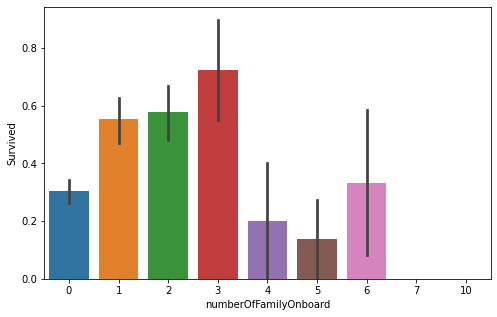

In [61]:
X['numberOfFamilyOnboard'] = X['SibSp'] + X['Parch']
X_test['numberOfFamilyOnboard'] = X_test['SibSp'] + X_test['Parch']

print(X.groupby(by='numberOfFamilyOnboard')['numberOfFamilyOnboard'].count())

fig = plt.figure(figsize=(8,5))
sns.barplot(x='numberOfFamilyOnboard',y='Survived',data=X)

In [44]:
X['isAlone'] = X['SibSp'] + X['Parch'] > 0
X_test['isAlone'] = X_test['SibSp'] + X_test['Parch'] > 0

Deck
A     58
B    159
C     85
D    142
E    166
F    223
G     53
T      5
Name: Deck, dtype: int64


<AxesSubplot:xlabel='Deck', ylabel='Survived'>

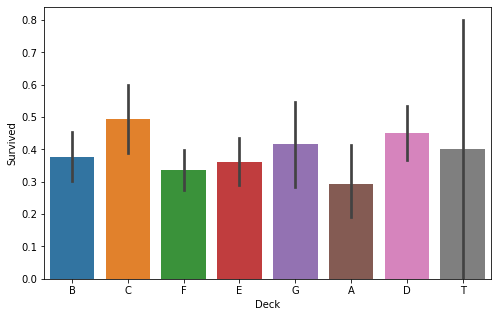

In [45]:
print(X.groupby(by='Deck')['Deck'].count())

fig = plt.figure(figsize=(8,5))
sns.barplot(x='Deck',y='Survived',data=X)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

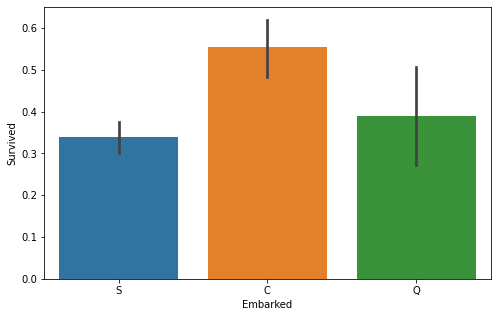

In [46]:
fig = plt.figure(figsize=(8,5))
sns.barplot(x='Embarked',y='Survived', data=X)

C
         Survived      Pclass         Age       SibSp       Parch        Fare  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean     0.553571    1.886905   30.690476    0.386905    0.363095   59.954144   
std      0.498608    0.944100   14.045671    0.557213    0.660481   83.912994   
min      0.000000    1.000000    0.000000    0.000000    0.000000    4.012500   
25%      0.000000    1.000000   22.000000    0.000000    0.000000   13.697950   
50%      1.000000    1.000000   29.000000    0.000000    0.000000   29.700000   
75%      1.000000    3.000000   39.000000    1.000000    1.000000   78.500025   
max      1.000000    3.000000   71.000000    2.000000    3.000000  512.329200   

       numberOfFamilyOnboard  
count             168.000000  
mean                0.750000  
std                 0.926974  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 1.000000  
max                 

,Survived,Pclass,Age,SibSp,Parch,Fare,numberOfFamilyOnboard,isAlone
Embarked,,,,,,,,
C,1,1,29,0,0,29.70,0,False
Q,0,3,27,0,0,7.75,0,False
S,0,3,28,0,0,13.00,0,False


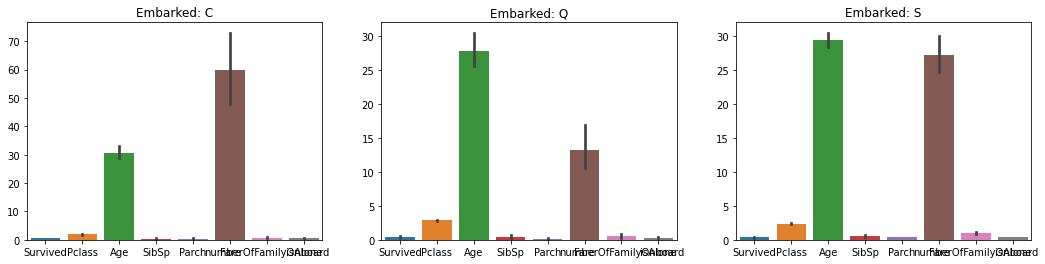

In [47]:
fig = plt.figure(figsize=(18,4))

i = 0
grps = X.groupby('Embarked')
for Embarked, Embarked_df in grps:
    print(Embarked)
    print(Embarked_df.describe())
    i += 1
    fig.add_subplot(1,3,i)
    sns.barplot(data=Embarked_df).set_title('Embarked: ' + Embarked)  
    
grps.median()

In [48]:
# drop Embarked for now
X = X.drop(['Embarked'], axis=1)
X_test = X_test.drop(['Embarked'], axis=1)

In [49]:
X.shape, X_test.shape

((891, 12), (418, 11))

## Feature selection with categorical data

Since this is a classification problem, the two most commonly used feature selection methods for categorical input data when the target variable is also categorical are the chi-squared and the mutual information.

https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [50]:
# prepare input data
def prepare_inputs(X_train):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    return X_train_enc  

# prepare target
def prepare_targets(y_train):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    return y_train_enc #, y_test_enc

# feature selection
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

X_temp = X.copy()
y_temp = X_temp['Survived']
X_temp = X_temp.drop(['Survived'],axis=1)

# split into train and test sets
X_train, X_train_test, y_train, y_train_test = train_test_split(X_temp, y_temp, test_size=0.33)
# prepare input data
X_train_enc = prepare_inputs(X_train)
# prepare output data
y_train_enc = prepare_targets(y_train)

<AxesSubplot:xlabel='feature', ylabel='score'>

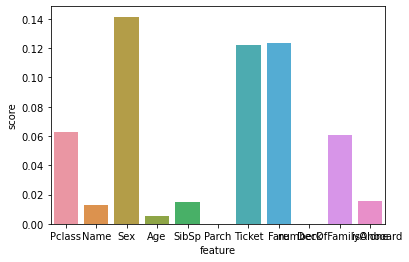

In [51]:
# feature selection
X_train_fs, fs = select_features(X_train_enc, y_train_enc)

# what are scores for the features
df1= pd.DataFrame(X_temp.columns)
df2 = pd.DataFrame(fs.scores_)

df = pd.concat([df1,df2],axis=1)
df.columns = ['feature','score']
sns.barplot(x='feature', y='score', data=df)

In [52]:
X.shape, X_test.shape

((891, 12), (418, 11))

In [68]:
X_temp

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Deck,numberOfFamilyOnboard,isAlone
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B,1,True
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,True
3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,F,0,False
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C,1,True
5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,F,0,False
...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,D,0,False
888,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B,0,False
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25,1,2,W./C. 6607,23.4500,F,3,True


## Scaling the features

In [37]:
X.shape, X_test.shape

((891, 12), (418, 11))

In [38]:
y = X['Survived']
X = X.drop(['Survived'],axis=1)

In [39]:
X.shape, X_test.shape

((891, 11), (418, 11))

In [40]:
X_all = pd.concat([X, X_test])

In [41]:
X_all.shape

(1309, 11)

In [42]:
numerical_features = X_all.select_dtypes(exclude='object').columns
scaler = StandardScaler()
X_all[numerical_features] = scaler.fit_transform(X_all[numerical_features])

In [43]:
X_all.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Deck,numberOfFamilyOnboard,isAlone
PassengerId,,,,,,,,,,,
1,0.841916,"Braund, Mr. Owen Harris",male,-0.570401,0.481288,-0.445,A/5 21171,-0.503282,B,0.073352,1.233758
2,-1.546098,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.622695,0.481288,-0.445,PC 17599,0.734749,C,0.073352,1.233758
3,0.841916,"Heikkinen, Miss. Laina",female,-0.272127,-0.479087,-0.445,STON/O2. 3101282,-0.490231,F,-0.558346,-0.810532
4,-1.546098,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.398990,0.481288,-0.445,113803,0.383190,C,0.073352,1.233758
5,0.841916,"Allen, Mr. William Henry",male,0.398990,-0.479087,-0.445,373450,-0.487814,F,-0.558346,-0.810532


In [44]:
X.shape, X_test.shape, y.shape, X_all.shape

((891, 11), (418, 11), (891,), (1309, 11))

In [45]:
X_all.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Deck,numberOfFamilyOnboard,isAlone
PassengerId,,,,,,,,,,,
1,0.841916,"Braund, Mr. Owen Harris",male,-0.570401,0.481288,-0.445,A/5 21171,-0.503282,B,0.073352,1.233758
2,-1.546098,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.622695,0.481288,-0.445,PC 17599,0.734749,C,0.073352,1.233758
3,0.841916,"Heikkinen, Miss. Laina",female,-0.272127,-0.479087,-0.445,STON/O2. 3101282,-0.490231,F,-0.558346,-0.810532
4,-1.546098,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.398990,0.481288,-0.445,113803,0.383190,C,0.073352,1.233758
5,0.841916,"Allen, Mr. William Henry",male,0.398990,-0.479087,-0.445,373450,-0.487814,F,-0.558346,-0.810532


In [46]:
X_all = pd.get_dummies(X_all).reset_index(drop=True)
X_all.head()

,Pclass,Age,SibSp,Parch,Fare,numberOfFamilyOnboard,isAlone,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward",...,Ticket_W/C 14208,Ticket_WE/P 5735,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0.841916,-0.570401,0.481288,-0.445,-0.503282,0.073352,1.233758,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-1.546098,0.622695,0.481288,-0.445,0.734749,0.073352,1.233758,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.841916,-0.272127,-0.479087,-0.445,-0.490231,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-1.546098,0.398990,0.481288,-0.445,0.383190,0.073352,1.233758,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.841916,0.398990,-0.479087,-0.445,-0.487814,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [47]:
X_all.shape

(1309, 2253)

In [48]:
X_all.loc[len(y):]

,Pclass,Age,SibSp,Parch,Fare,numberOfFamilyOnboard,isAlone,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward",...,Ticket_W/C 14208,Ticket_WE/P 5735,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
891,0.841916,0.324421,-0.479087,-0.445000,-0.492083,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
892,0.841916,1.293812,0.481288,-0.445000,-0.508115,0.073352,1.233758,0,0,0,...,0,0,0,1,0,0,0,0,0,0
893,-0.352091,2.412340,-0.479087,-0.445000,-0.456155,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
894,0.841916,-0.197558,-0.479087,-0.445000,-0.475972,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
895,0.841916,-0.570401,0.481288,0.710763,-0.405886,0.705051,1.233758,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.841916,0.846401,-0.479087,-0.445000,-0.487814,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1305,-1.546098,0.697264,-0.479087,-0.445000,1.462037,-0.558346,-0.810532,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1306,0.841916,0.622695,-0.479087,-0.445000,-0.503282,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1307,0.841916,-0.272127,-0.479087,-0.445000,-0.487814,-0.558346,-0.810532,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
X_final = X_all.loc[:len(y)-1]
y_final = y
X_test_final = X_all.loc[len(y):]

In [50]:
X_final.shape, y_final.shape, X_test_final.shape

((891, 2253), (891,), (418, 2253))

## ML - LogisticRegression

In [51]:
# Instantiate our model
logreg = LogisticRegression(random_state=0)
# Fit our model to the training data
logreg.fit(X_final, y_final)
# Predict on the test data
pred = logreg.predict(X_test_final)

In [52]:
output = pd.DataFrame({'PassengerId': X_test_final.index + 1,
                       'Survived': pred})
output.to_csv('my_submission.csv', index=False)

0.77033 do not delete name and ticket

0.76555  combine sib and par

0.76315  LogisticRegression submission

## ML - RadomForest

In [53]:
random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(X_final, y_final)

random_forest_predictions = random_forest_model.predict(X_test_final)

output = pd.DataFrame({'PassengerId': X_test_final.index + 1,
                       'Survived': random_forest_predictions})
output.to_csv('RF_prediction_Titanic.csv', index=False)

Change RF model estimator from 100 to 500 is not an improvement from our best score

Change RF model estimator from 100 to 1000 is not an improvement from our best score

Dropping Name, impact the result negatively 

After dropping Embarked, the score remain the same!!!! 0.78708. Also test the logistic regression which is still not perform as well as RF


Add total family number X['numberOfFamily'] = X['SibSp'] + X['Parch']
                        X_test['numberOfFamily'] = X_test['SibSp'] + X_test['Parch']
improved score to 0.78708!!!!! rank up to #4886 top 13% 

After changing to X_test['Fare'].fillna(X_test[(X_test['Pclass']==3) & (X_test['Embarked']=='S')]['Fare'].mean())
                from X_test['Fare'].fillna(X_test['Fare'].mean())
The score has decreased to 0.77272
even though I have not backed out this change since it makes sense. 


After adding deck info, there is no change in score

9510 score 0.77990 7th. submission top 25%

Reference: https://www.kaggle.com/lourenswalters/ii-titanic-exploratory-data-analysis-0-80

